https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

### Setup your environment

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1, l2

print(tf.__version__)

2.2.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num CPUs Available:  1


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [5]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

import pathlib
import shutil
import tempfile

In [6]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

#### Helper Functions

#### That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [7]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

# https://www.tensorflow.org/tutorials/text/transformer
### A transformer model handles variable-sized input using stacks of self-attention layers instead of RNNs or CNNs.

### https://arxiv.org/abs/1706.03762

### https://www.tensorflow.org/api_docs/python/tf/clip_by_value

### we want to set our learning rates to these parameters based on the step

<span style="color:red">
    
# Note:
>I got some errors around this function, saying it couldn't convert 0.05 and 1.000002 to type int64, so I enclosed them in int() to get it to run on GCP.  Gave me wonky results

In [8]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self):
    super(CustomSchedule, self).__init__()
    
  def __call__(self, step):
    lr = tf.clip_by_value(0.05 / 1.0000002**step, clip_value_min=0.000001, clip_value_max=0.05)
    return lr

### Define the optimizer based on the learner schedule. 
### Paper uses SGD
### https://github.com/uci-igb/higgs-susy/blob/master/higgs/layers4_width300_lr005_m200_wd000001_all.py
### https://www.researchgate.net/publication/263704884_Searching_for_Exotic_Particles_in_High-Energy_Physics_with_Deep_Learning

In [9]:
def get_optimizer():
  lr_schedule = CustomSchedule()
  return tf.keras.optimizers.SGD(lr_schedule, momentum=0.9)

#### Next include callbacks.EarlyStopping to avoid long and unnecessary training times. Note that this callback is set to monitor the val_binary_crossentropy, not the val_loss. This difference will be important later.
#### Use callbacks.TensorBoard to generate TensorBoard logs for the training.

In [10]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', min_delta=0.00001, patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [11]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.AUC(name='AUC'),
                  tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=2)
  return history

## Dataset download, otherwise use local copy

In [12]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')

### Each example has 28 features, there are 11000000 examples

In [13]:
FEATURES = 28

### This should be used to read the csv directly unpacking from the gzip file without unpacking

In [14]:
ds = tf.data.experimental.CsvDataset( gz,[float(),]*(FEATURES+1), compression_type="GZIP")

### working in batches of 10000 use the map function to following function repacks that list of scalars into a (feature_vector, label) pair.

In [15]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

### Have a look at some of the records from this new packed_ds. The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


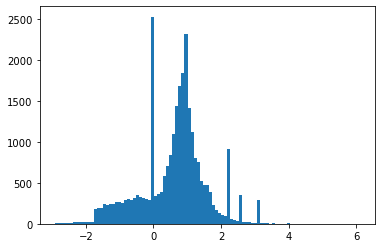

In [16]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

#### This is what 1 observation looks like. 

In [17]:
print(list(ds.take(2).as_numpy_iterator())[0])
print(list(ds.take(2).as_numpy_iterator())[1])

(1.0, 0.8692932, -0.6350818, 0.22569026, 0.32747006, -0.6899932, 0.75420225, -0.24857314, -1.0920639, 0.0, 1.3749921, -0.6536742, 0.9303491, 1.1074361, 1.1389043, -1.5781983, -1.0469854, 0.0, 0.65792954, -0.01045457, -0.04576717, 3.1019614, 1.35376, 0.9795631, 0.97807616, 0.92000484, 0.72165745, 0.98875093, 0.87667835)
(1.0, 0.9075421, 0.32914728, 0.35941187, 1.4979699, -0.31300953, 1.0955306, -0.5575249, -1.5882298, 2.1730762, 0.8125812, -0.21364193, 1.2710146, 2.2148721, 0.49999395, -1.2614318, 0.73215616, 0.0, 0.3987009, -1.1389301, -0.0008191102, 0.0, 0.3022199, 0.83304816, 0.98569965, 0.9780984, 0.77973217, 0.99235576, 0.7983426)


In [18]:
featVals=[features.numpy()[0] for features,label in packed_ds.take(1000)]

t=packed_ds.take(20000)

In [19]:
t = [label.numpy() for features,label in packed_ds.take(20000)]
print("Values 1:",sum(t))
print("Values 0:",sum(np.equal(t,0)))

Values 1: 10457.0
Values 0: 9543


In [20]:
t = np.array([features.numpy() for features,label in packed_ds.take(20000)])
print("Min Value:",min(t.flatten()))
print("Max Value:",max(t.flatten()))

Min Value: -2.960813
Max Value: 16.131908


### TODO: Note that the paper used 100, we can increase this to reduce training time.

In [21]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500  
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

### At the same time, use the Dataset.cache method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [22]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [23]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [24]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [25]:
tf.range(25, dtype=tf.float32)

<tf.Tensor: shape=(25,), dtype=float32, numpy=
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.],
      dtype=float32)>

Text(0.5, 0, 'Train Step')

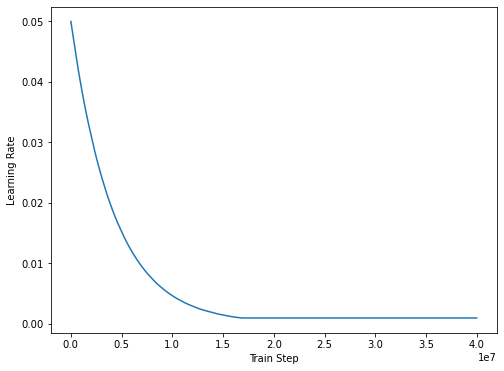

In [26]:
temp_lr_schedule = CustomSchedule()
plt.figure(figsize = (8,6))
lrs = temp_lr_schedule(tf.range(40000000, dtype=tf.float32))
plt.plot(lrs)
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [27]:
lrs

<tf.Tensor: shape=(40000000,), dtype=float32, numpy=
array([0.05      , 0.04999999, 0.04999998, ..., 0.00091578, 0.00091578,
       0.00091578], dtype=float32)>

In [28]:
size_histories = {}

##  Paper: https://archive.ics.uci.edu/ml/datasets/HIGGS
### https://github.com/uci-igb/higgs-susy/blob/master/higgs/layers4_width300_lr005_m200_wd000001_all.py
### https://www.tensorflow.org/api_docs/python/tf/keras/initializers/RandomNormal

#### Basically this tells our models where to initialize for each layer in the deep learning model

In [29]:

first_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=42)
outer_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.001, seed=42)
other_initializers = tf.keras.initializers.RandomNormal(mean=0., stddev=0.05, seed=42)


weight_decay=0.00001
paper_model = tf.keras.Sequential([
    layers.Dense(300, activation='tanh', input_shape=(FEATURES,), kernel_initializer=first_initializer, kernel_regularizer=l2(weight_decay)),
    layers.Dense(300, activation='tanh', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dense(300, activation='tanh', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dense(300, activation='tanh', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dropout(0.5), 
    layers.Dense(1, activation='sigmoid', kernel_initializer=outer_initializer, kernel_regularizer=l2(weight_decay))
    
])

## Paper Model Architecture 

In [30]:
size_histories['paper'] = compile_and_fit(paper_model, 'sizes/paper')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               8700      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_3 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 301       
Total params: 279,901
Trainable params: 279,901
Non-trainable params: 0
__________________________________________________

Epoch 36/10000
.20/20 - 0s - loss: 0.6703 - AUC: 0.6679 - binary_crossentropy: 0.6628 - accuracy: 0.5925 - val_loss: 0.6708 - val_AUC: 0.6650 - val_binary_crossentropy: 0.6632 - val_accuracy: 0.5920
Epoch 37/10000
.20/20 - 0s - loss: 0.6718 - AUC: 0.6633 - binary_crossentropy: 0.6643 - accuracy: 0.5825 - val_loss: 0.6710 - val_AUC: 0.6643 - val_binary_crossentropy: 0.6634 - val_accuracy: 0.5920
Epoch 38/10000
.20/20 - 0s - loss: 0.6684 - AUC: 0.6732 - binary_crossentropy: 0.6608 - accuracy: 0.6061 - val_loss: 0.6699 - val_AUC: 0.6640 - val_binary_crossentropy: 0.6623 - val_accuracy: 0.5680
Epoch 39/10000
.20/20 - 0s - loss: 0.6670 - AUC: 0.6773 - binary_crossentropy: 0.6594 - accuracy: 0.6049 - val_loss: 0.6684 - val_AUC: 0.6725 - val_binary_crossentropy: 0.6608 - val_accuracy: 0.6150
Epoch 40/10000
.20/20 - 0s - loss: 0.6683 - AUC: 0.6738 - binary_crossentropy: 0.6607 - accuracy: 0.6040 - val_loss: 0.6692 - val_AUC: 0.6664 - val_binary_crossentropy: 0.6616 - val_accuracy: 0.5960
Epoch

Epoch 78/10000
.20/20 - 1s - loss: 0.6585 - AUC: 0.6972 - binary_crossentropy: 0.6508 - accuracy: 0.6384 - val_loss: 0.6627 - val_AUC: 0.6825 - val_binary_crossentropy: 0.6550 - val_accuracy: 0.5850
Epoch 79/10000
.20/20 - 1s - loss: 0.6593 - AUC: 0.6937 - binary_crossentropy: 0.6516 - accuracy: 0.6296 - val_loss: 0.6701 - val_AUC: 0.6954 - val_binary_crossentropy: 0.6624 - val_accuracy: 0.6550
Epoch 80/10000
.20/20 - 1s - loss: 0.6574 - AUC: 0.6939 - binary_crossentropy: 0.6497 - accuracy: 0.6364 - val_loss: 0.6607 - val_AUC: 0.6782 - val_binary_crossentropy: 0.6530 - val_accuracy: 0.5980
Epoch 81/10000
.20/20 - 1s - loss: 0.6490 - AUC: 0.7164 - binary_crossentropy: 0.6413 - accuracy: 0.6623 - val_loss: 0.6590 - val_AUC: 0.6950 - val_binary_crossentropy: 0.6513 - val_accuracy: 0.6210
Epoch 82/10000
.20/20 - 1s - loss: 0.6475 - AUC: 0.7194 - binary_crossentropy: 0.6398 - accuracy: 0.6659 - val_loss: 0.6573 - val_AUC: 0.6969 - val_binary_crossentropy: 0.6496 - val_accuracy: 0.6330
Epoch

Epoch 119/10000
.20/20 - 1s - loss: 0.6370 - AUC: 0.7373 - binary_crossentropy: 0.6291 - accuracy: 0.6907 - val_loss: 0.6568 - val_AUC: 0.6947 - val_binary_crossentropy: 0.6489 - val_accuracy: 0.6500
Epoch 120/10000
.20/20 - 1s - loss: 0.6416 - AUC: 0.7269 - binary_crossentropy: 0.6337 - accuracy: 0.6797 - val_loss: 0.6563 - val_AUC: 0.7014 - val_binary_crossentropy: 0.6484 - val_accuracy: 0.6400
Epoch 121/10000
.20/20 - 1s - loss: 0.6352 - AUC: 0.7372 - binary_crossentropy: 0.6273 - accuracy: 0.6935 - val_loss: 0.6515 - val_AUC: 0.7102 - val_binary_crossentropy: 0.6435 - val_accuracy: 0.6580
Epoch 122/10000
.20/20 - 0s - loss: 0.6337 - AUC: 0.7429 - binary_crossentropy: 0.6258 - accuracy: 0.6984 - val_loss: 0.6589 - val_AUC: 0.6853 - val_binary_crossentropy: 0.6510 - val_accuracy: 0.6100
Epoch 123/10000
.20/20 - 0s - loss: 0.6372 - AUC: 0.7368 - binary_crossentropy: 0.6293 - accuracy: 0.6877 - val_loss: 0.6587 - val_AUC: 0.6948 - val_binary_crossentropy: 0.6508 - val_accuracy: 0.6270


Epoch 160/10000
.20/20 - 0s - loss: 0.6260 - AUC: 0.7561 - binary_crossentropy: 0.6179 - accuracy: 0.7144 - val_loss: 0.6628 - val_AUC: 0.6811 - val_binary_crossentropy: 0.6546 - val_accuracy: 0.6090
Epoch 161/10000
.20/20 - 0s - loss: 0.6244 - AUC: 0.7564 - binary_crossentropy: 0.6162 - accuracy: 0.7218 - val_loss: 0.6598 - val_AUC: 0.6791 - val_binary_crossentropy: 0.6517 - val_accuracy: 0.6130
Epoch 162/10000
.20/20 - 0s - loss: 0.6242 - AUC: 0.7590 - binary_crossentropy: 0.6160 - accuracy: 0.7214 - val_loss: 0.6572 - val_AUC: 0.6893 - val_binary_crossentropy: 0.6490 - val_accuracy: 0.6370
Epoch 163/10000
.20/20 - 0s - loss: 0.6246 - AUC: 0.7576 - binary_crossentropy: 0.6165 - accuracy: 0.7236 - val_loss: 0.6509 - val_AUC: 0.7045 - val_binary_crossentropy: 0.6428 - val_accuracy: 0.6740
Epoch 164/10000
.20/20 - 0s - loss: 0.6217 - AUC: 0.7622 - binary_crossentropy: 0.6135 - accuracy: 0.7271 - val_loss: 0.6532 - val_AUC: 0.6900 - val_binary_crossentropy: 0.6451 - val_accuracy: 0.6430


Epoch 201/10000

Epoch: 200, AUC:0.7869,  accuracy:0.7601,  binary_crossentropy:0.5995,  loss:0.6080,  val_AUC:0.6815,  val_accuracy:0.6340,  val_binary_crossentropy:0.6520,  val_loss:0.6605,  
.20/20 - 0s - loss: 0.6080 - AUC: 0.7869 - binary_crossentropy: 0.5995 - accuracy: 0.7601 - val_loss: 0.6605 - val_AUC: 0.6815 - val_binary_crossentropy: 0.6520 - val_accuracy: 0.6340
Epoch 202/10000
.20/20 - 0s - loss: 0.6094 - AUC: 0.7869 - binary_crossentropy: 0.6010 - accuracy: 0.7558 - val_loss: 0.6580 - val_AUC: 0.6842 - val_binary_crossentropy: 0.6496 - val_accuracy: 0.6500
Epoch 203/10000
.20/20 - 0s - loss: 0.6093 - AUC: 0.7848 - binary_crossentropy: 0.6009 - accuracy: 0.7571 - val_loss: 0.6603 - val_AUC: 0.6887 - val_binary_crossentropy: 0.6518 - val_accuracy: 0.6450
Epoch 204/10000
.20/20 - 0s - loss: 0.6115 - AUC: 0.7811 - binary_crossentropy: 0.6030 - accuracy: 0.7487 - val_loss: 0.6578 - val_AUC: 0.6889 - val_binary_crossentropy: 0.6493 - val_accuracy: 0.6540
Epoch 205/10000
.20/20

.20/20 - 0s - loss: 0.5922 - AUC: 0.8115 - binary_crossentropy: 0.5834 - accuracy: 0.7996 - val_loss: 0.6590 - val_AUC: 0.6749 - val_binary_crossentropy: 0.6503 - val_accuracy: 0.6350
Epoch 242/10000
.20/20 - 0s - loss: 0.6120 - AUC: 0.7825 - binary_crossentropy: 0.6033 - accuracy: 0.7508 - val_loss: 0.6608 - val_AUC: 0.6654 - val_binary_crossentropy: 0.6520 - val_accuracy: 0.6270
Epoch 243/10000
.20/20 - 0s - loss: 0.5952 - AUC: 0.8068 - binary_crossentropy: 0.5864 - accuracy: 0.7894 - val_loss: 0.6625 - val_AUC: 0.6733 - val_binary_crossentropy: 0.6537 - val_accuracy: 0.6380
Epoch 244/10000
.20/20 - 0s - loss: 0.5905 - AUC: 0.8140 - binary_crossentropy: 0.5817 - accuracy: 0.8018 - val_loss: 0.6604 - val_AUC: 0.6789 - val_binary_crossentropy: 0.6517 - val_accuracy: 0.6460
Epoch 245/10000
.20/20 - 0s - loss: 0.5908 - AUC: 0.8130 - binary_crossentropy: 0.5820 - accuracy: 0.8007 - val_loss: 0.6586 - val_AUC: 0.6787 - val_binary_crossentropy: 0.6498 - val_accuracy: 0.6510
Epoch 246/10000


Epoch 283/10000
.20/20 - 0s - loss: 0.5823 - AUC: 0.8275 - binary_crossentropy: 0.5733 - accuracy: 0.8194 - val_loss: 0.6634 - val_AUC: 0.6525 - val_binary_crossentropy: 0.6544 - val_accuracy: 0.6280
Epoch 284/10000
.20/20 - 0s - loss: 0.5826 - AUC: 0.8283 - binary_crossentropy: 0.5736 - accuracy: 0.8193 - val_loss: 0.6670 - val_AUC: 0.6557 - val_binary_crossentropy: 0.6579 - val_accuracy: 0.6110
Epoch 285/10000
.20/20 - 0s - loss: 0.5838 - AUC: 0.8257 - binary_crossentropy: 0.5748 - accuracy: 0.8170 - val_loss: 0.6662 - val_AUC: 0.6640 - val_binary_crossentropy: 0.6571 - val_accuracy: 0.6320
Epoch 286/10000
.20/20 - 0s - loss: 0.5812 - AUC: 0.8301 - binary_crossentropy: 0.5721 - accuracy: 0.8217 - val_loss: 0.6638 - val_AUC: 0.6725 - val_binary_crossentropy: 0.6547 - val_accuracy: 0.6490
Epoch 287/10000
.20/20 - 0s - loss: 0.5805 - AUC: 0.8300 - binary_crossentropy: 0.5714 - accuracy: 0.8251 - val_loss: 0.6646 - val_AUC: 0.6599 - val_binary_crossentropy: 0.6556 - val_accuracy: 0.6280


.20/20 - 0s - loss: 0.6021 - AUC: 0.8017 - binary_crossentropy: 0.5929 - accuracy: 0.7771 - val_loss: 0.6672 - val_AUC: 0.6424 - val_binary_crossentropy: 0.6579 - val_accuracy: 0.6270
Epoch 324/10000
.20/20 - 0s - loss: 0.5872 - AUC: 0.8253 - binary_crossentropy: 0.5779 - accuracy: 0.8092 - val_loss: 0.6694 - val_AUC: 0.6395 - val_binary_crossentropy: 0.6601 - val_accuracy: 0.6150
Epoch 325/10000
.20/20 - 0s - loss: 0.5849 - AUC: 0.8311 - binary_crossentropy: 0.5756 - accuracy: 0.8130 - val_loss: 0.6668 - val_AUC: 0.6547 - val_binary_crossentropy: 0.6576 - val_accuracy: 0.6380
Epoch 326/10000
.20/20 - 0s - loss: 0.5806 - AUC: 0.8345 - binary_crossentropy: 0.5713 - accuracy: 0.8241 - val_loss: 0.6631 - val_AUC: 0.6497 - val_binary_crossentropy: 0.6539 - val_accuracy: 0.6250
Epoch 327/10000
.20/20 - 0s - loss: 0.5789 - AUC: 0.8361 - binary_crossentropy: 0.5696 - accuracy: 0.8286 - val_loss: 0.6685 - val_AUC: 0.6586 - val_binary_crossentropy: 0.6593 - val_accuracy: 0.6310
Epoch 328/10000


In [31]:
size_histories['paper'].history['AUC'][0:10]

[0.5029281973838806,
 0.5285380482673645,
 0.5525993704795837,
 0.5617892742156982,
 0.5826312303543091,
 0.5899243354797363,
 0.6022430658340454,
 0.6117173433303833,
 0.6257873773574829,
 0.6316566467285156]

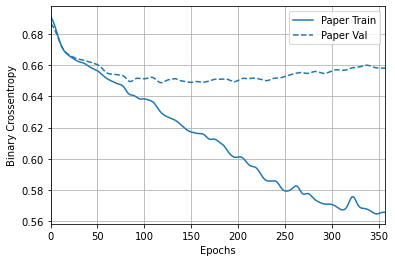

In [32]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)

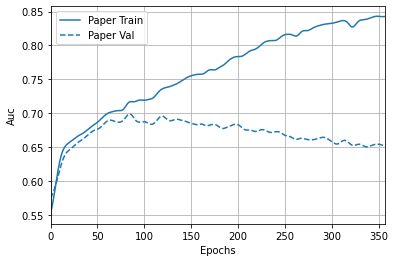

In [33]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'AUC', smoothing_std=10)
plotter.plot(size_histories)

Text(0.5, 0, 'Epochs [Log Scale]')

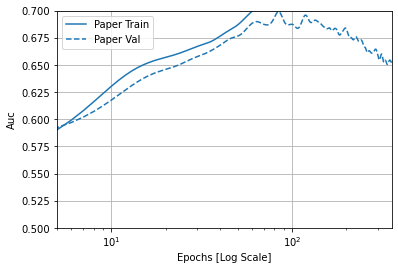

In [34]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

In [35]:
%tensorboard --logdir {logdir}/sizes

UsageError: Line magic function `%tensorboard` not found.


In [36]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

<span style="color:Blue">
    
# Updated Model

>Increase batch size to 500 from 100 to decrease training time

In [ ]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500  
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [ ]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [ ]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

>Paper Architecture

In [ ]:
first_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=42)
outer_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.001, seed=42)
other_initializers = tf.keras.initializers.RandomNormal(mean=0., stddev=0.05, seed=42)


weight_decay=0.00001
paper_model = tf.keras.Sequential([
    layers.Dense(300, activation='tanh', input_shape=(FEATURES,), kernel_initializer=first_initializer, kernel_regularizer=l2(weight_decay)),
    layers.Dense(300, activation='tanh', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dense(300, activation='tanh', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dense(300, activation='tanh', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dropout(0.5), 
    layers.Dense(1, activation='sigmoid', kernel_initializer=outer_initializer, kernel_regularizer=l2(weight_decay))
    
])

# Potential Improvements

<span style="color:red">
    
## Activation Functions

</span>

##### Sigmoid

1/1(e^-bx)

>Pros:

>Cons:
Vanishing/exploding Gradient problem.  Extremely low weights backpropigate and end up vanishing near the input neruons
Non-zero Centered - This causes weights to be either all positive or all negative

##### Tanh (Current)

(2/1(e^-2x))-1

Generally preferred over sigmoid



>Pros:
Output is zero-centered, which makes optimization easier

>Cons:
Also sufferes from the vanishing gradient problem

##### Relu (Has become very popular over the past few years)

0 for X < 0
x for x >= 0

Anything less than zero is zero, positive values increase with a slope of 1.

Note: only for hidden layers.  Softmax possibly for output?


>Pros:

6x improvement vs tanh in covergence (ImageNet Classification with Deep Convolutional Neural Networks by Krizhevsky)
Much simpler so it runs faster
Avoids vanishing gradient problem

>Cons:

Can cause dead neurons (dying relu problem).  If a major weight update hits, that neuron could potentially not activate again. Leaky Relu was introduced to fix this problem
Leaky Relu has a small negative slope for values x < 0

https://www.youtube.com/watch?v=s-V7gKrsels

<span style="color:red">

#### Proposal: Leaky Relu or Elu activation for hidden layers

</span>

Since the output is binary, I don't know if it matters if we were to use Softmax over Sigmoid.


<span style="color:red">
    
## Hidden Layers

</span>


<span style="color:red">

#####  Proposal: 
</span>

>From what I've found, it sounds like the hidden layers should be about the same size as the number of inputs?

<span style="color:red">

# Learning Rate

<span/>


"Learning rate is arguably the most importnat hyperparameter of the model"
https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/

Trial and error is suggested to optimize.  Using a 'learning rate schedule' is considered best practice. 

------------------

https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0

“Cyclical Learning Rates for Training Neural Networks” - Leslie N. Smith 2015

Effective learning rate estimation technique:

    1.Train the network starting at a very low learning rate, increasing it exponentially with each batch
    
   ![](lr_vs_batch.jpg)
   


    2.Record the learning rate and training loss for every batch; plot learning rate vs loss

![](lr_vs_loss.jpg)

    3. Select the point in the graph with the fastest decrease in loss (deriv. loss wrt learning rate)
    
 ![](dloss_wrt_lr.jpg)    
 
 
     Fastest decrease would be the minimum value, so we can see that it's 10e-2 on this graph.  

<span style="color:red">

## Weight Decay

<span/>

--------------------

https://arxiv.org/pdf/1907.08931.pdf

Adaptive weight decay?

.00001 seems like it wouldn't really do much


## Preprocessing question

"Data sets. The data sets were nearly balanced, with 53% positive examples in the
HIGGS data set and 46% positive examples in the SUSY data set. Input features
were standardized over the entire training/test set with mean 0 and s.d. 1, except
for those features with values strictly 40—these we scaled so that the mean
value was 1." https://www.nature.com/articles/ncomms5308.pdf

Does this normalization technique make sense?

In [ ]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500  
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [ ]:
first_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1, seed=42)
outer_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.001, seed=42)
other_initializers = tf.keras.initializers.RandomNormal(mean=0., stddev=0.05, seed=42)


weight_decay=0.01
updated_model = tf.keras.Sequential([
    layers.Dense(28, activation='relu', input_shape=(FEATURES,), kernel_initializer=first_initializer, kernel_regularizer=l2(weight_decay)),
    layers.Dense(28, activation='relu', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dense(28, activation='relu', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dense(28, activation='relu', kernel_initializer=other_initializers, kernel_regularizer=l2(weight_decay)),
    layers.Dropout(0.2), 
    layers.Dense(1, activation='sigmoid', kernel_initializer=outer_initializer, kernel_regularizer=l2(weight_decay))
    
])

In [ ]:
size_histories['updated'] = compile_and_fit(paper_model, 'sizes/updated')